In [12]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Dataset
from typing import Tuple

from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic

import pickle
import requests

import random

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
        
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [ ]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [4]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [5]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

#plt.imshow(img)

In [6]:
idx2label.index("orange")

950

In [7]:
#List containing names of the images to create the dictionary
key_names = ['West_Highland_white_terrier', 'American_coot', 'racer', 'flamingo', 'kite', 'goldfish', 'tiger_shark', 'vulture', 'common_iguana', 'orange']

#Parameters
params = {
    "labels": (1,),
    "hide_color": None,
    "top_labels": 5,
    "num_features": 100000,
    "num_samples": 1000,
    "batch_size": 10,
    "segmentation_fn": None,
    "distance_metric": "cosine",
    "model_regressor": None,
    "random_seed": None
}

#Here the dummy code assigns same parameters to each key/image but you need to put your own parameters for each image
all_params = {}
for i in key_names:
    all_params[i] = params

In [8]:
sample_images = os.listdir('../data/')

for i in range(len(sample_images)):
    img = get_image('../data/' + sample_images[i])
    print(sample_images[i][10:-5])


racer
vulture
flamingo
orange
American_coot
tiger_shark
kite
common_iguana
West_Highland_white_terrier
goldfish


Explaining goldfish:


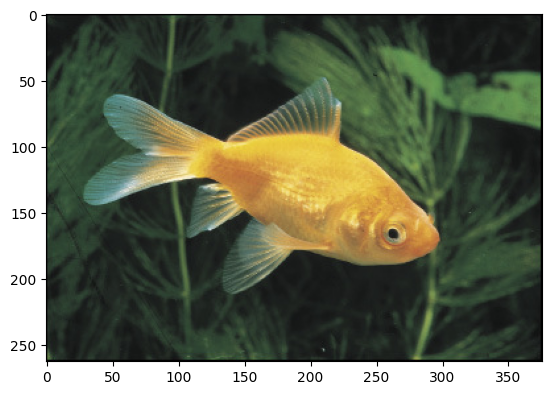

Seed: 92


  0%|          | 0/200 [00:00<?, ?it/s]

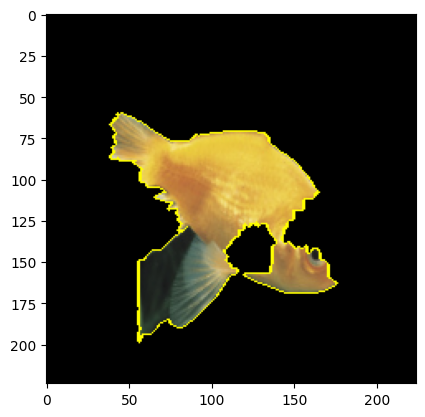

Seed: 96


  0%|          | 0/200 [00:00<?, ?it/s]

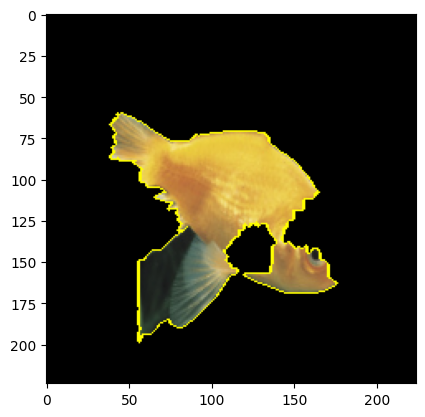

Seed: 97


  0%|          | 0/200 [00:00<?, ?it/s]

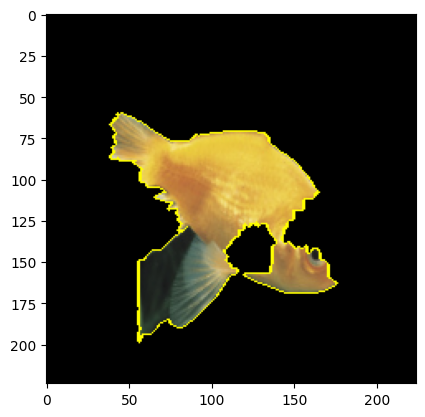

Seed: 43


  0%|          | 0/200 [00:00<?, ?it/s]

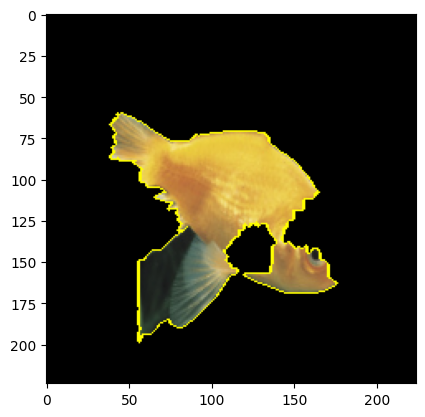

In [197]:
sample_images = os.listdir('../data/')
c = 9
class_name = sample_images[c][10:-5]
print(f"Explaining {class_name}:")
img = get_image('../data/' + sample_images[c])
plt.imshow(img)
plt.show()
color = [None, (0,0,0), (128,128,128), (255,255,255)]
for i in range(4):
    #params = all_params[name]
    seed = random.randint(1,100)
    print(f"Seed: {seed}")
    params = {
        "labels": (1,),
        "hide_color": color[3],
        "top_labels": 1,
        "num_features": 4,
        "num_samples": 200,
        "batch_size": 8,
        "segmentation_fn": None,# lambda x: slic(x, n_segments=1, compactness=50),
        "distance_metric": "cosine",
        "model_regressor": None,
        "random_seed": None
    }
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         labels=params["labels"],
                                         hide_color=params["hide_color"],
                                         top_labels=params["top_labels"],
                                         num_features=params["num_features"],
                                         num_samples=params["num_samples"],
                                         batch_size=params["batch_size"],
                                         segmentation_fn=params["segmentation_fn"],
                                         distance_metric=params["distance_metric"],
                                         model_regressor=params["model_regressor"],
                                         random_seed=params["random_seed"])

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, hide_rest=True)
    img_boundry1 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry1)
    plt.show()

#img_t = get_input_tensors(img)
#model.eval()
#logits = model(img_t)
#probs = F.softmax(logits, dim=1)
#probs5 = probs.topk(5)
#tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

In [198]:
all_params[class_name] = params

In [199]:
#Saving the pickle file
submission = 'submission/submission.pkl'
with open(submission, "wb") as f:
    pickle.dump(all_params, f)

In [200]:
#Submission, remember to add your token number!
response = requests.post("http://34.122.51.94:9091/lime", files={"file": open(submission, "rb")}, headers={"token": "11395516"})
print(response.json())

{'avg_iou': 0.334783209795884, 'avg_time': 1.9471065044403075}
